<a href="https://colab.research.google.com/github/LindsClar/Real_Estate_Rep/blob/main/Predicting_CA_Property_Through_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How I'll be approaching the data.

The data contains all the sales documented on Zillow from 2018 to 2024 for every state in the United States.

I'll be cleaning the data then narrowing the data to only California.



In [ ]:
#import packages normal backages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#read CSV files
df = pd.read_csv('/content/USRealEstateTrends.csv')

In [ ]:
#Analyze information
df.head()

,RegionID,SizeRank,RegionName,StateName,2018-02-HomeValue,2018-02-DaysPending,2018-02-CutRaw,2018-03-HomeValue,2018-03-DaysPending,2018-03-CutRaw,...,2024-02-CutRaw,2024-03-HomeValue,2024-03-DaysPending,2024-03-CutRaw,2024-04-HomeValue,2024-04-DaysPending,2024-04-CutRaw,2024-05-HomeValue,2024-05-DaysPending,2024-05-CutRaw
0,102001,0,United States,NaN,225746.614318,52.0,7600.0,227155.648994,48.0,8900.0,...,10000.0,357374.362080,42.0,10000.0,359240.114070,38.0,10000.0,360681.294250,37.0,10000.0
1,394913,1,"New York, NY",NY,468313.430126,68.0,16000.0,470102.249154,63.0,19751.5,...,25000.0,646508.747102,55.0,25000.0,652619.099940,51.0,26000.0,657279.223513,47.0,30000.0
2,753899,2,"Los Angeles, CA",CA,629019.165765,33.0,20000.0,636850.139417,31.0,20000.0,...,30000.5,952665.578913,32.0,34000.0,956266.687926,29.0,40012.0,962388.491425,28.0,40000.0
3,394463,3,"Chicago, IL",IL,229741.266973,52.0,8000.0,231317.183706,42.0,9100.0,...,10000.0,316875.294320,29.0,10000.0,319764.144323,25.0,10000.0,321897.252361,23.0,10000.0
4,394514,4,"Dallas, TX",TX,241533.231800,46.0,8562.0,243401.180622,42.0,9900.0,...,10000.0,379972.349667,42.0,10000.0,380957.392395,38.0,10000.0,381103.625851,38.0,10000.0


In [ ]:
#clean/fill missing data
#rename column name
df.rename(index=str, columns={'RegionName' : 'Location', 'StateName':'State'}, inplace=True)

#dropping the not needed
df.dropna(inplace=True)

#identifying missing values
df.isna().sum()

,0
RegionID,0
SizeRank,0
Location,0
State,0
2018-02-HomeValue,0
...,...
2024-04-DaysPending,0
2024-04-CutRaw,0
2024-05-HomeValue,0
2024-05-DaysPending,0


In [ ]:
#Melting Data - melted data allows you to split the dataset by time
df_melt=pd.melt(df, id_vars=['RegionID','SizeRank','Location','State',], var_name='Year_Month_Parameters', value_name='Values')

df_melt[['Year', 'Month_Parameters']] = df_melt['Year_Month_Parameters'].str.split('-', expand=True, n=1)
df_melt.drop('Year_Month_Parameters', axis=1, inplace=True)

#Organize so melted DF shows a column of month
df_melt[['Month', 'Parameters']] = df_melt['Month_Parameters'].str.split('-', expand=True, n=1)
df_melt.drop(columns = ['Month_Parameters'], inplace=True)

df_melt.head()


,RegionID,SizeRank,Location,State,Values,Year,Month,Parameters
0,394913,1,"New York, NY",NY,468313.430126,2018,02,HomeValue
1,753899,2,"Los Angeles, CA",CA,629019.165765,2018,02,HomeValue
2,394463,3,"Chicago, IL",IL,229741.266973,2018,02,HomeValue
3,394514,4,"Dallas, TX",TX,241533.231800,2018,02,HomeValue
4,394692,5,"Houston, TX",TX,208651.872272,2018,02,HomeValue


In [ ]:
# Pivot the DataFrame to have measures as columns
df_reorganized = df_melt.pivot_table(index=['RegionID','SizeRank','Location','State','Year','Month'], columns='Parameters', values='Values').reset_index()
df_reorganized.head(5)

Parameters,RegionID,SizeRank,Location,State,Year,Month,CutRaw,DaysPending,HomeValue
0,394308,64,"Albany, NY",NY,2018,02,5100.0,64.0,218876.519605
1,394308,64,"Albany, NY",NY,2018,03,7000.0,62.0,219792.863791
2,394308,64,"Albany, NY",NY,2018,04,8000.0,54.0,220505.058669
3,394308,64,"Albany, NY",NY,2018,05,9000.0,45.0,221526.705984
4,394308,64,"Albany, NY",NY,2018,06,9100.0,47.0,222479.931387


In [ ]:
#focus to CA  - filter the DF
CA = df_reorganized.loc[df_reorganized['State']=='CA']

In [ ]:
#Correcting time
CA['Date'] = pd.to_datetime(CA['Year'].astype(str) + '-' + CA['Month'].astype(str))
print(CA['Date'].head())

304   2018-02-01
305   2018-03-01
306   2018-04-01
307   2018-05-01
308   2018-06-01
Name: Date, dtype: datetime64[ns]


<ipython-input-10-870d248f46d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA['Date'] = pd.to_datetime(CA['Year'].astype(str) + '-' + CA['Month'].astype(str))


In [ ]:
CA.head()

Parameters,RegionID,SizeRank,Location,State,Year,Month,CutRaw,DaysPending,HomeValue,Date
304,394357,63,"Bakersfield, CA",CA,2018,02,7000.0,51.0,212531.666950,2018-02-01
305,394357,63,"Bakersfield, CA",CA,2018,03,7100.0,48.0,213905.260766,2018-03-01
306,394357,63,"Bakersfield, CA",CA,2018,04,6000.0,46.0,214996.109254,2018-04-01
307,394357,63,"Bakersfield, CA",CA,2018,05,7600.0,47.0,216057.814209,2018-05-01
308,394357,63,"Bakersfield, CA",CA,2018,06,8000.0,48.0,217117.256125,2018-06-01


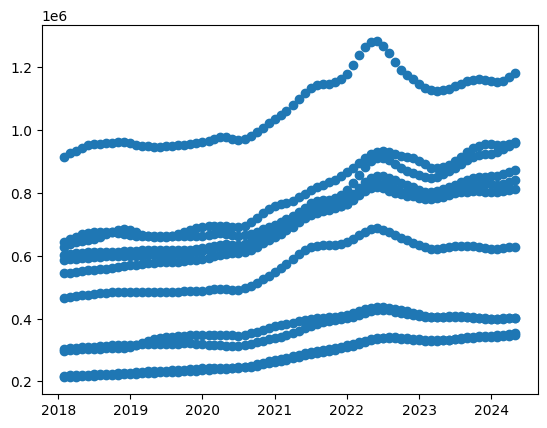

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(CA['Date'], CA['HomeValue'])

# Model
 Now we'll be testing and implimenting different models to inspect home value increate.
  1. Linear Regression


In [ ]:
#Locating the # of unique values
CA["Location"].nunique()
CA["Location"].unique()

array(['Bakersfield, CA', 'Chico, CA', 'Oxnard, CA', 'Salinas, CA',
       'San Diego, CA', 'San Francisco, CA', 'Santa Rosa, CA',
       'Truckee, CA', 'Visalia, CA', 'Los Angeles, CA', 'Sonora, CA'],
      dtype=object)

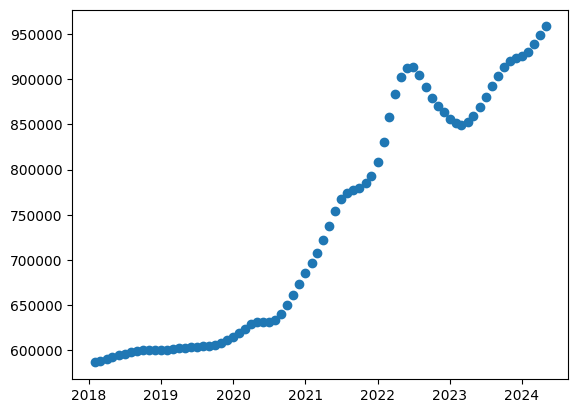

In [ ]:
#Focusing on one city homevalues that were consistly recoreded for the State of CA
CA_SD = CA[CA['Location']=='San Diego, CA']

plt.scatter(CA_SD['Date'], CA_SD['HomeValue'])

Data Preparation for Linear Regression
  - best fit curve or line representing the relationship between these two variables. If the relation between dependent variable and independent variable is a straight line or establishing a linear relationship

In [ ]:
CA_SD.info()

CA_SD['Date'] = CA_SD['Date'].map(pd.Timestamp.toordinal)

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 6916 to 6991
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RegionID     76 non-null     int64         
 1   SizeRank     76 non-null     int64         
 2   Location     76 non-null     object        
 3   State        76 non-null     object        
 4   Year         76 non-null     object        
 5   Month        76 non-null     object        
 6   CutRaw       76 non-null     float64       
 7   DaysPending  76 non-null     float64       
 8   HomeValue    76 non-null     float64       
 9   Date         76 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 6.5+ KB


<ipython-input-15-72ef459dbd8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_SD['Date'] = CA_SD['Date'].map(pd.Timestamp.toordinal)


In [ ]:
#defining X and y

X = CA_SD[['Date']]
y = CA_SD['HomeValue']

In [ ]:
#import library
from sklearn.model_selection import train_test_split

#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=False)


In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

In [ ]:
clf.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_test.head()

,HomeValue
6969,913153.036869
6970,904947.747440
6971,891490.618975
6972,879394.082138
6973,870207.266855


In [ ]:
clf.score(X_test, y_test)

0.02507934596610384

This demonstates a really low predictive accuracy using linear Regression, despite the the low accuracy I will still be plotting the linear regression model.

In [ ]:
print(f'This is the R2 Score : {clf.score(X_test, y_test)}')

This is the R2 Score : 0.02507934596610384


In [ ]:
#import to mean squared error
from sklearn.metrics import mean_squared_error,r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'This is the root of the Mean Squared Error : {rmse}')

This is the root of the Mean Squared Error : 32419.459238149804


In [ ]:
#r2
r2 = r2_score(y_test, y_pred)
print(f'This is the R2 Score : {r2}')

This is the R2 Score : 0.02507934596610384


In [ ]:
#testing the length before plotting the data
print(len(X_test), len(y_test), len(y_pred))

23 23 23


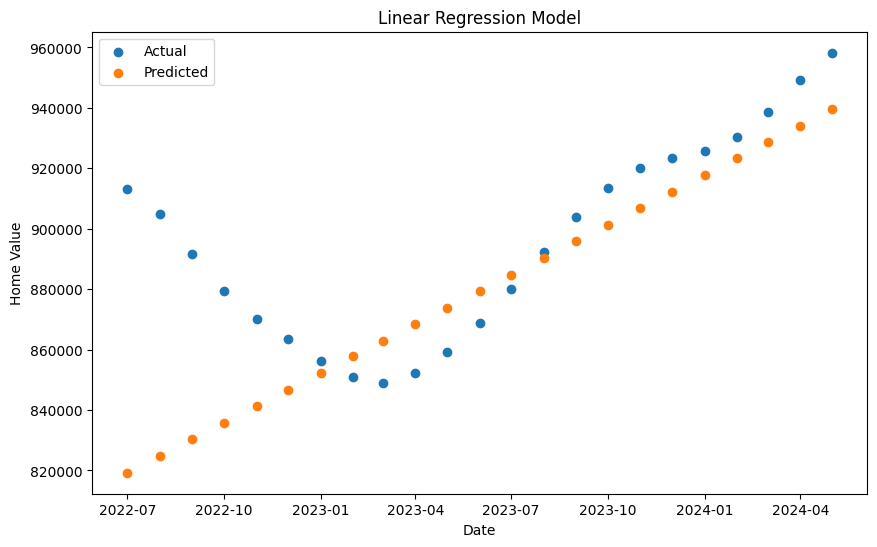

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.map(pd.Timestamp.fromordinal), y_test)
plt.scatter(X_test.map(pd.Timestamp.fromordinal), y_pred)
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.title('Linear Regression Model')
plt.legend(['Actual', 'Predicted'])
plt.show()

2. ARIMA - Autoregressive Integrated Moving Average
  - This model uses historical data to forecast for future values and it doesn't take into account external features, such as natural disasters.


In [ ]:
#importing libraries for arima modeling
from statsmodels.tsa.arima.model import ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

                               SARIMAX Results                                
Dep. Variable:              HomeValue   No. Observations:                   53
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -557.165
Date:                Mon, 11 Nov 2024   AIC                           1120.330
Time:                        22:21:13   BIC                           1126.184
Sample:                             0   HQIC                          1122.574
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.63e-05   6.14e+04      0.000       1.000       1.000
ma.L1         -0.9999      0.002   -515.159      0.000      -1.004      -0.996
sigma2      1.906e+07   3.91e-13   4.87e+19      0.0

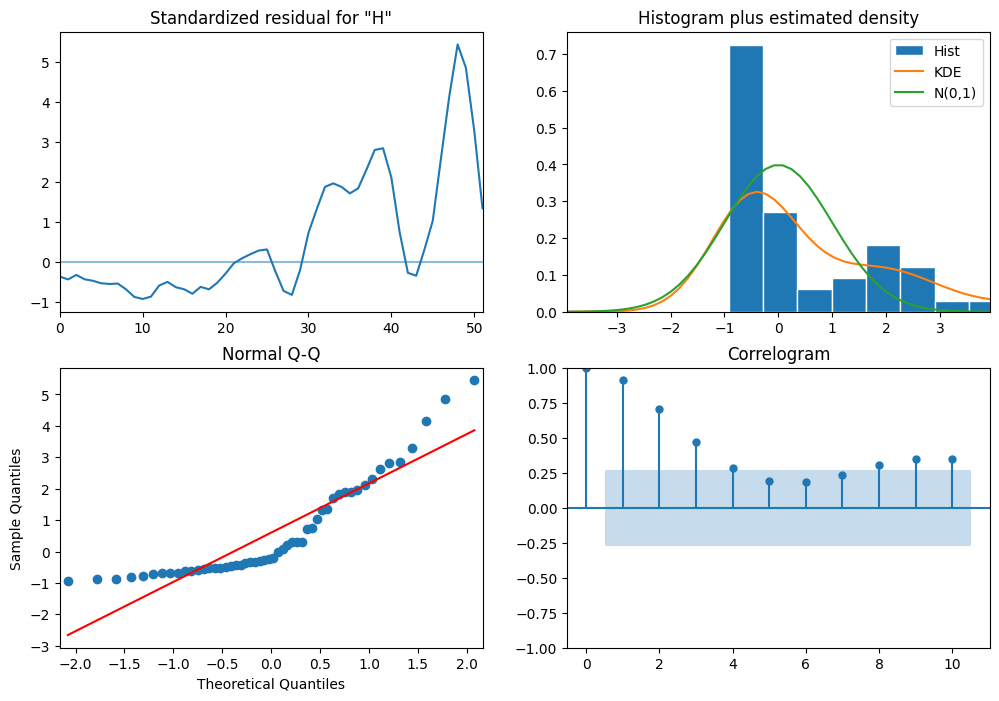

In [ ]:
#The seasonal order is denoted by (P, D, Q, m)
order = (1, 1, 1)

#ARIMA model object
model = ARIMA(y_train, order=order)

#fit the model to the data
fitted_model = model.fit()

#print model's summary
print(fitted_model.summary())

#plot
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

Now we us the model to forecast future values of the time series. Forecasted values are the predicted values of the time series

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


There are the forecasted values: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x7f240b2ea380>
There are the forecasted predicted mean values: 53    917214.313757
54    921606.771644
55    925999.228493
56    930391.684304
57    934784.139077
58    939176.592811
59    943569.045508
60    947961.497167
61    952353.947787
62    956746.397370
Name: predicted_mean, dtype: float64
    lower HomeValue  upper HomeValue
53    908636.869566    925791.757949
54    909446.468407    933767.074882
55    911069.349798    940929.107188
56    913109.975538    947673.393070
57    915415.568792    954152.709361
58    917907.990395    960445.195227
59    920540.948333    966597.142683
60    923284.363074    972638.631260
61    926117.398636    978590.496938
62    929024.926406    984467.868334


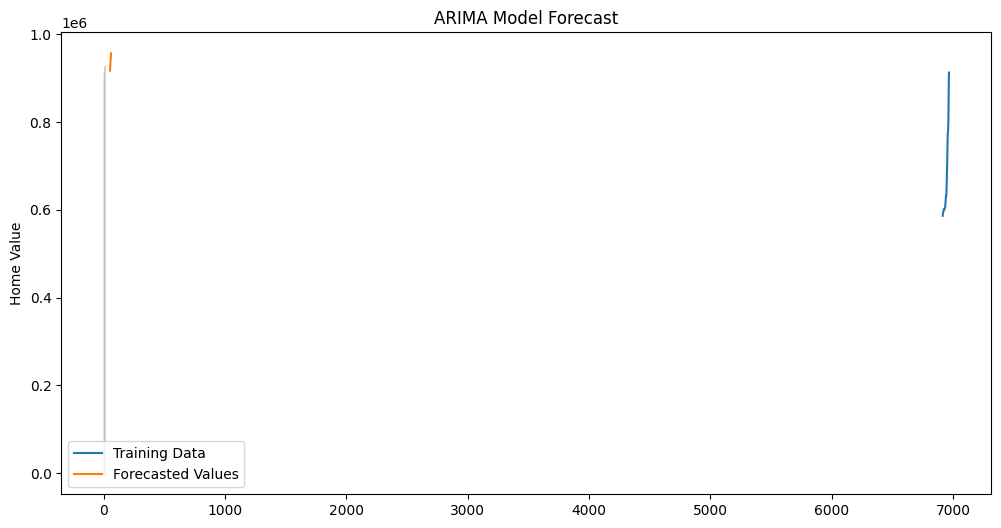

In [ ]:
#forcasting the next 5 values
forecast = fitted_model.get_forecast(steps=10)
#print Forcasted values
print(f'There are the forecasted values: {forecast}')

#Extracting values
forecast_values = forecast.predicted_mean
print(f'There are the forecasted predicted mean values: {forecast_values}')

#confidence interval
forecast_ci = forecast.conf_int()
print(forecast_ci)

#plot
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Training Data')
plt.plot(forecast_values, label='Forecasted Values')
#plt.plot(residuals)
plt.fill_between(range(len(forecast_ci)), len(forecast_ci)+10, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='grey', alpha=0.3)
#plt.xlabel('Date')
plt.ylabel('Home Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()